In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

In [34]:
simulation_start_date = date(2023, 2, 1)
results_root_dir='/Users/kiran/agentfil/exp'

experiment_dirs = [
    "nagents-125_type-greedy_optimism-3",
    "nagents-125_type-greedy_optimism-4",
    "nagents-25_type-greedy_optimism-4",
    "nagents-25_type-greedy_optimism-3",
    "nagents-5_type-greedy_optimism-3",
    "nagents-5_type-greedy_optimism-4",
]

experiment_names = experiment_dirs  # can rename for plot purposes

In [35]:
def plot_experiments(keys, experiment_dirs, 
                     labels=None,
                     x_post_process=None, y_post_process=None, 
                     x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if x_post_process is None:
        x_post_fn = lambda x: x
    else:
        x_post_fn = x_post_process
        
    if y_post_process is None:
        y_post_fn = lambda x: x
    else:
        y_post_fn = y_post_process
    
    for ii, exp in enumerate(experiment_dirs):
        plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
        
        data_path = os.path.join(results_root_dir, exp, 'filecoin_df.csv')
        df = pd.read_csv(data_path)

        if labels is not None:
            l = labels[ii]
        else:
            l = str(exp)
            
        if len(keys)==1:
            k = keys[0]
            x = x_post_fn(df[x_key])
            y = y_post_fn(df[k])
            plt.plot(x, y, label=l, **plot_kwargs)
        else:
            # get all keys and call the combine function
            key_data = {}
            for k in keys:
                key_data[k] = df[k]
            x = x_post_fn(df[x_key])
            y = y_post_fn(key_data)
            plt.plot(x, y, label=l, **plot_kwargs)
    
    plt.xticks(rotation=60)

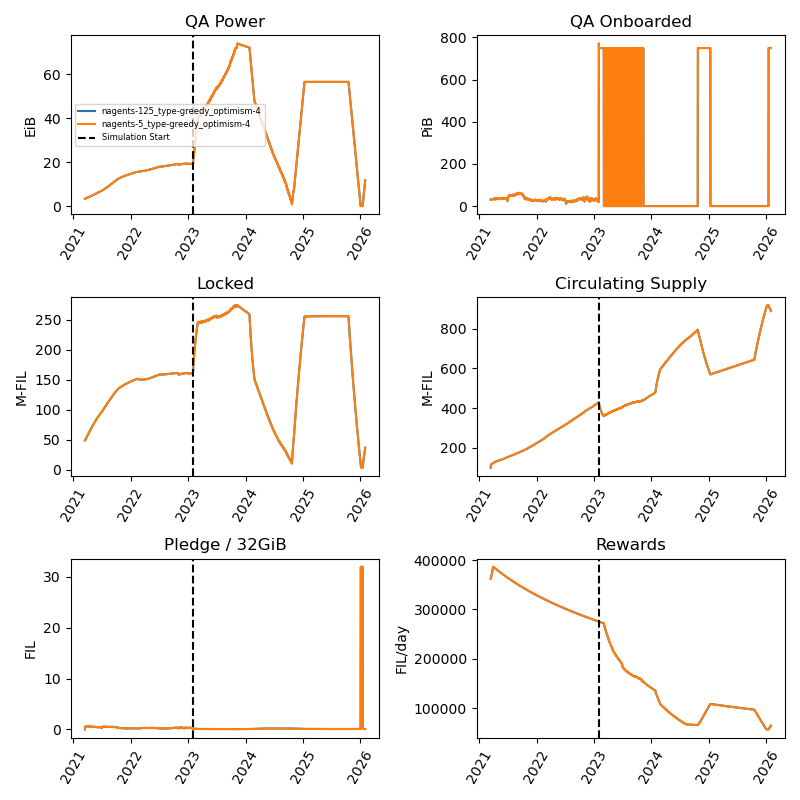

In [36]:
def x_post_fn(x_ser_in):
    x_ser_in = pd.to_datetime(x_ser_in)
    return x_ser_in
def y_post_fn(y_ser_in):
    y_ser_in /= 1_000_000
    return y_ser_in

plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plot_experiments(['total_qa_power_eib'], experiment_dirs, x_post_process=x_post_fn)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.ylabel('EiB')
plt.title('QA Power')

plt.subplot(3,2,2)
plot_experiments(['day_onboarded_qap_pib'], experiment_dirs, x_post_process=x_post_fn)
plt.title('QA Onboarded')
plt.ylabel('PiB')

plt.subplot(3,2,3)
plot_experiments(['network_locked'], experiment_dirs, x_post_process=x_post_fn, y_post_process=y_post_fn)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.title('Locked')

plt.subplot(3,2,4)
plot_experiments(['circ_supply'], experiment_dirs, x_post_process=x_post_fn, y_post_process=y_post_fn)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.title('Circulating Supply')

plt.subplot(3,2,5)
plot_experiments(['day_pledge_per_QAP'], experiment_dirs, x_post_process=x_post_fn)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.title('Pledge / 32GiB')

plt.subplot(3,2,6)
plot_experiments(['day_network_reward'], experiment_dirs, x_post_process=x_post_fn)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.title('Rewards')

plt.tight_layout()

plt.show()